In [1]:
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.svm import *
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.naive_bayes import *
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn.discriminant_analysis import *

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df=pd.read_csv('data.csv')

In [3]:
y = df['Bankrupt?']
df=df.drop(columns=['Bankrupt?',' Net Income Flag'])

In [4]:
for col in df.columns:
    if max(df[col]) > 1:
        df[col]=minmax_scale(np.log1p(df[col]))

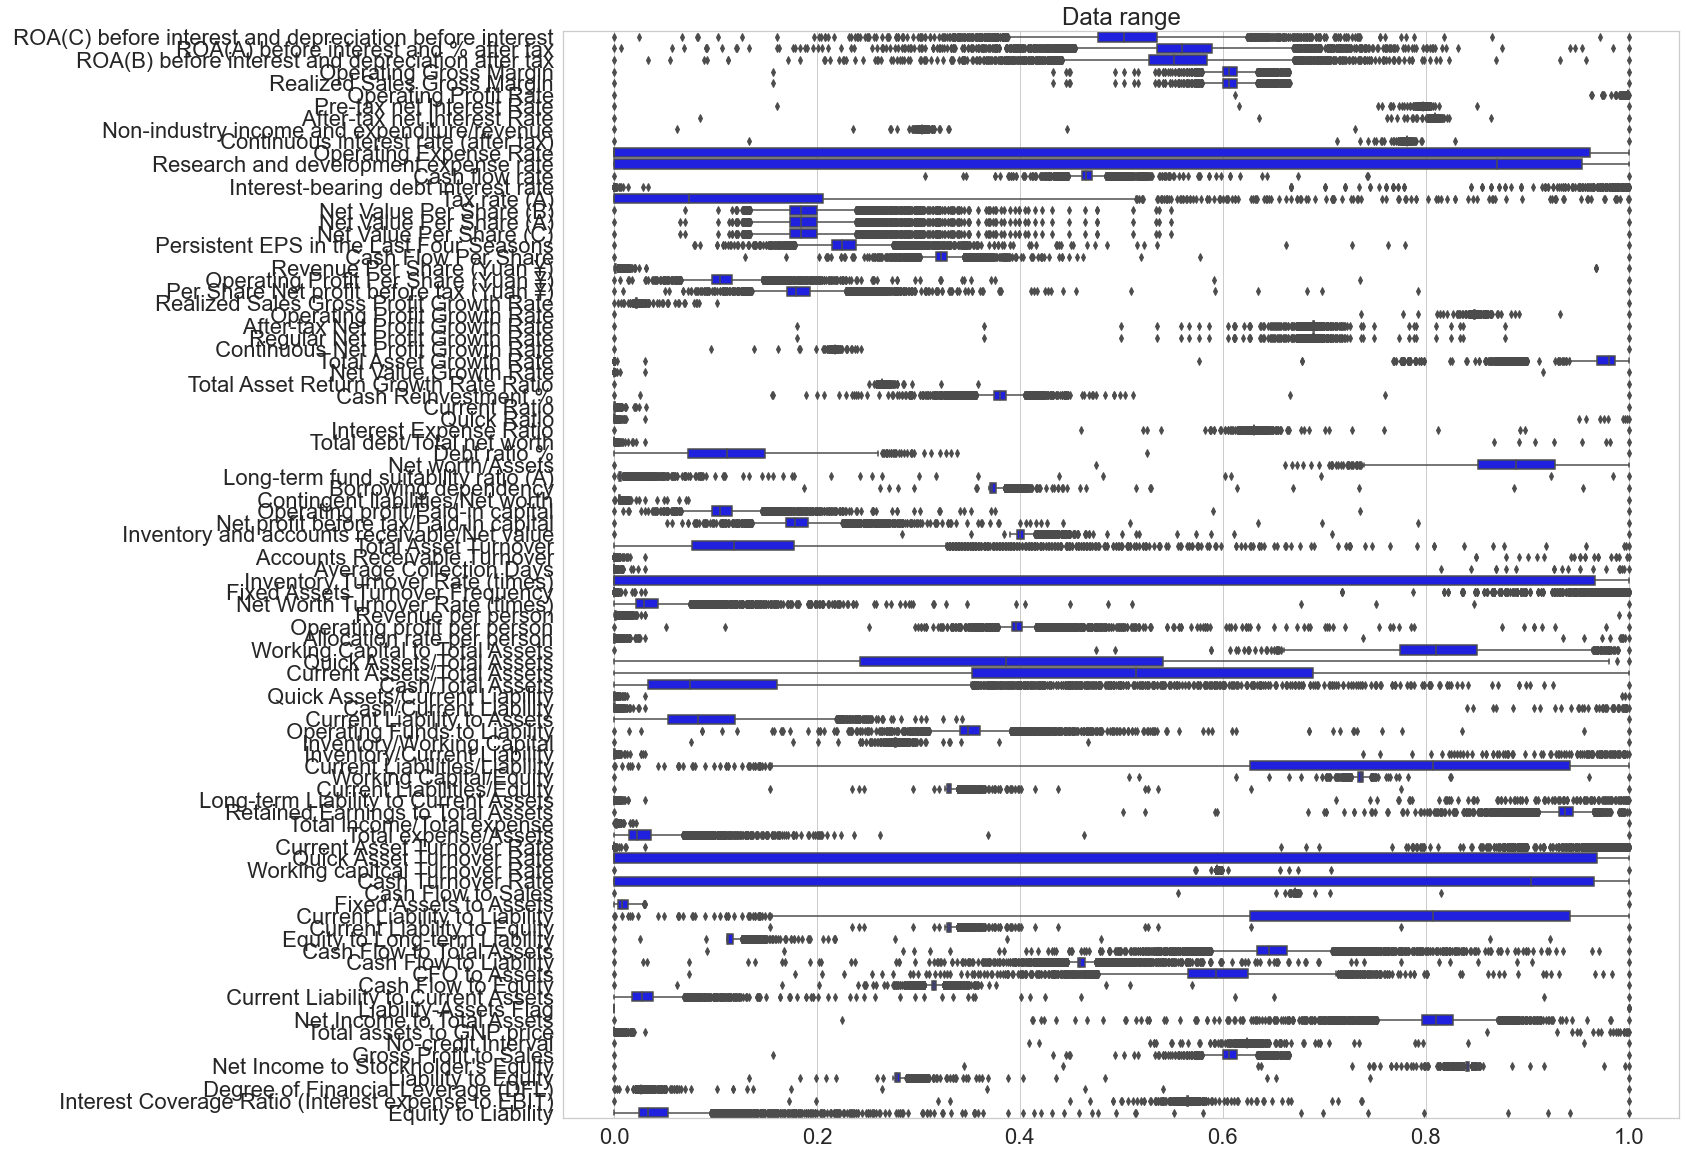

In [5]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
sns.set_style('whitegrid')
sns.set_palette('bwr')
sns.boxplot(data = df, orient='h', color='blue')
plt.title('Data range')
plt.show();

### Training and test set prep

In [6]:
#Simple 80-20
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, stratify = y, random_state=50)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

((5455, 94), (5455,))

((1364, 94), (1364,))

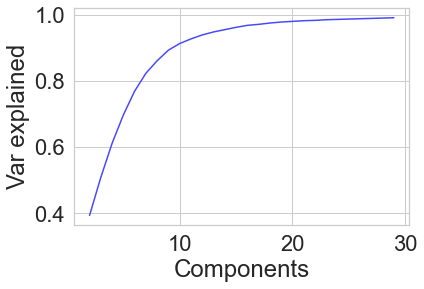

In [7]:
pca_var = pd.DataFrame(columns=['Components', 'Var explained'])

for i in np.arange(2, 30):
    pca=PCA(n_components=i).fit(X_train)
    sum_var = pca.explained_variance_ratio_.sum()
    pca_var=pca_var.append({'Components':i, 'Var explained':round(sum_var, 3)}, ignore_index=True)

sns.lineplot(data=pca_var, x='Components', y='Var explained');

In [8]:
#PCA
pca = PCA(10).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
#Random Oversampling
oversample=RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
X_train_over.shape
y_train_over.value_counts()

(10558, 94)

1    5279
0    5279
Name: Bankrupt?, dtype: int64

In [10]:
#SMOTE
oversample=SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
X_train_smote.shape
y_train_smote.value_counts()

(10558, 94)

1    5279
0    5279
Name: Bankrupt?, dtype: int64

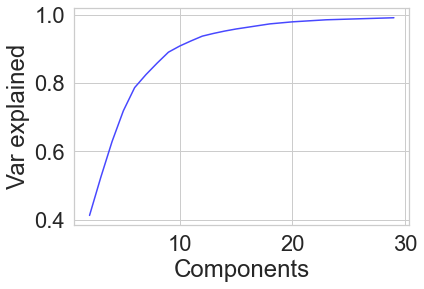

In [12]:
pca_var = pd.DataFrame(columns=['Components', 'Var explained'])

for i in np.arange(2, 30):
    pca=PCA(n_components=i).fit(X_train_smote)
    sum_var = pca.explained_variance_ratio_.sum()
    pca_var=pca_var.append({'Components':i, 'Var explained':round(sum_var, 3)}, ignore_index=True)

sns.lineplot(data=pca_var, x='Components', y='Var explained');

#### Modeling functions

In [9]:
cols=['FN', 'FP', 'TP', 'TN', 'FPR', 'TPR', 'ACC', 'PREC', 'F1', 'F1 micro', 'F1 macro', 'F1 weighted']
results = pd.DataFrame(columns=cols)

In [12]:
random_state = 50
kf = StratifiedKFold(n_splits= 3, shuffle=True, random_state = random_state)

def score(model, train=X_train, y=y_train):
    f1=cross_val_score(model, train, y, n_jobs=-1, scoring='f1', cv=kf)
    return print('mean f1:', f1.mean(), 'std:', f1.std())

def output(model, name='', x=X_test, y=y_test):
    y_pred=model.predict(x)
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))
    
    if name!='':
        fn = np.sum((y_pred==0) & (y_test==1))
        fp = np.sum((y_pred==1) & (y_test==0))
        tp = np.sum((y_pred==1) & (y_test==1))
        tn = np.sum((y_pred==0) & (y_test==0))
    
        fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1.0)
        acc = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)    
    
        f1_binary= f1_score(y, y_pred, average='binary')
        f1_micro= f1_score(y, y_pred, average='micro')
        f1_macro= f1_score(y, y_pred, average='macro')
        f1_weighted= f1_score(y, y_pred, average='weighted')
        global results
        scores=[fn, fp, tp, tn, fpr[1], tpr[1], acc, precision, f1_binary, f1_micro, f1_macro, f1_weighted]
        scores_series = pd.Series(scores, index=results.columns, name=name)
        results=results.append(scores_series, ignore_index=False)

    return

In [13]:
def allmodels(model, models=''):
    model.fit(X_train_pca, y_train)
    score(model, train=X_train_pca, y=y_train)
    output(model, name=(models + ' PCA'), x=X_test_pca, y=y_test)

    model.fit(X_train_over, y_train_over)
    score(model, train=X_train_over, y=y_train_over)
    output(model, name=(models + ' random over'), x=X_test, y=y_test)

    model.fit(X_train_smote, y_train_smote)
    score(model, train=X_train_smote, y=y_train_smote)
    output(model, name=(models + ' SMOTE'), x=X_test, y=y_test)
    return

### Lazy classifier

In [19]:
lazy_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=f1_score)
models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)
models.sort_values('Balanced Accuracy')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,f1_score,Time Taken
Model,,,,,,
RidgeClassifierCV,0.97,0.50,0.50,0.95,0.00,0.08
RidgeClassifier,0.97,0.50,0.50,0.95,0.00,0.05
CalibratedClassifierCV,0.97,0.50,0.50,0.95,0.00,1.78
DummyClassifier,0.94,0.51,0.51,0.94,0.04,0.04
SVC,0.97,0.51,0.51,0.95,0.04,0.43
RandomForestClassifier,0.97,0.52,0.52,0.95,0.08,2.24
PassiveAggressiveClassifier,0.97,0.54,0.54,0.96,0.16,0.04
ExtraTreesClassifier,0.97,0.56,0.56,0.96,0.20,0.43
Perceptron,0.96,0.56,0.56,0.96,0.19,0.04


## Logistic Regression

#### no parameters

In [67]:
log = LogisticRegression()
log.fit(X_train, y_train)
score(log)
output(log)

LogisticRegression()

mean f1: 0.1474617882315673 std: 0.06791953452555897
[[1317    3]
 [  39    5]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.62      0.11      0.19        44

    accuracy                           0.97      1364
   macro avg       0.80      0.56      0.59      1364
weighted avg       0.96      0.97      0.96      1364



In [68]:
log = Pipeline([('scale', PowerTransformer()),
                ('log', LogisticRegression())])
log.fit(X_train, y_train)
score(log)
output(log, 'LogisticReg')

Pipeline(steps=[('scale', PowerTransformer()), ('log', LogisticRegression())])

mean f1: 0.3066648616939669 std: 0.046106542879362285
[[1312    8]
 [  33   11]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.58      0.25      0.35        44

    accuracy                           0.97      1364
   macro avg       0.78      0.62      0.67      1364
weighted avg       0.96      0.97      0.96      1364



#### parameter tuning on LogisticRegression()

In [30]:
log = Pipeline([('scale', PowerTransformer()),
                ('log', LogisticRegression(penalty='elasticnet',
                                           solver='saga'))])

classweights=[]
for i in np.arange(1, 100, 10):
    classweights.append({0:1, 1:i})

param_grid = {'log__C': [0.001, 0.1, 0.5, 1, 10, 20, 40, 80, 100], 
              'log__class_weight':classweights,
              'log__l1_ratio':np.linspace(0, 1, 10).tolist()}

grid = GridSearchCV(log,
                    param_grid,
                    refit=True,
                    verbose=1, 
                    n_jobs=-1, 
                    cv=kf,
                    scoring='f1')
grid.fit(X_train,y_train)
grid.best_estimator_
grid.best_params_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:  9.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('scale', PowerTransformer()),
                                       ('log',
                                        LogisticRegression(penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'log__C': [0.001, 0.1, 0.5, 1, 10, 20, 40, 80, 100],
                         'log__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 11},
                                               {0: 1, 1: 21}, {0: 1, 1: 31},
                                               {0: 1, 1: 41}, {0: 1, 1: 51},
                                               {0: 1, 1: 61}, {0: 1, 1: 71},
                                               {0: 1, 1: 81}, {0: 1, 1: 91}],
                         'log__l1_ratio': [0.0, 0.1111111111111111,
                                           0.2222222222222222,
                              

Pipeline(steps=[('scale', PowerTransformer()),
                ('log',
                 LogisticRegression(C=0.001, class_weight={0: 1, 1: 11},
                                    l1_ratio=0.4444444444444444,
                                    penalty='elasticnet', solver='saga'))])

{'log__C': 0.001,
 'log__class_weight': {0: 1, 1: 11},
 'log__l1_ratio': 0.4444444444444444}

In [31]:
log = Pipeline([('scale', PowerTransformer()),
                ('log', LogisticRegression(penalty='elasticnet',
                                           solver='saga'))])

classweights=[]
for i in np.arange(9, 20, 10):
    classweights.append({0:1, 1:i})

param_grid = {'log__C': [0.0001, 0.0005, 0.001, 0.0015, 0.002], 
              'log__class_weight':classweights,
              'log__l1_ratio':np.linspace(0.3, 0.5, 10).tolist()}

grid = GridSearchCV(log,
                    param_grid,
                    refit=True,
                    verbose=1, 
                    n_jobs=-1, 
                    cv=kf,
                    scoring='f1')
grid.fit(X_train,y_train)
grid.best_estimator_
grid.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('scale', PowerTransformer()),
                                       ('log',
                                        LogisticRegression(penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'log__C': [0.0001, 0.0005, 0.001, 0.0015, 0.002],
                         'log__class_weight': [{0: 1, 1: 9}, {0: 1, 1: 19}],
                         'log__l1_ratio': [0.3, 0.3222222222222222,
                                           0.34444444444444444,
                                           0.36666666666666664,
                                           0.3888888888888889,
                                           0.4111111111111111,
                                           0.43333333333333335,
                                           0.45555555555555555,
                      

Pipeline(steps=[('scale', PowerTransformer()),
                ('log',
                 LogisticRegression(C=0.0015, class_weight={0: 1, 1: 9},
                                    l1_ratio=0.47777777777777775,
                                    penalty='elasticnet', solver='saga'))])

{'log__C': 0.0015,
 'log__class_weight': {0: 1, 1: 9},
 'log__l1_ratio': 0.47777777777777775}

#### optimal parameters

In [69]:
log = Pipeline([('scale', PowerTransformer()),
                ('log', LogisticRegression(penalty='elasticnet',
                                           solver='saga',
                                           C=0.0015,
                                           l1_ratio=0.47777777777777775,
                                           class_weight={0:1, 1:9}))])

log.fit(X_train, y_train)
score(log)
output(log, 'Tuned LogReg')

Pipeline(steps=[('scale', PowerTransformer()),
                ('log',
                 LogisticRegression(C=0.0015, class_weight={0: 1, 1: 9},
                                    l1_ratio=0.47777777777777775,
                                    penalty='elasticnet', solver='saga'))])

mean f1: 0.397849157054126 std: 0.04899004196481084
[[1292   28]
 [  25   19]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.40      0.43      0.42        44

    accuracy                           0.96      1364
   macro avg       0.69      0.71      0.70      1364
weighted avg       0.96      0.96      0.96      1364



#### with PCA, oversampling, and SMOTE

In [70]:
allmodels(log, 'Log')

mean f1: 0.0 std: 0.0
[[1320    0]
 [  44    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364

mean f1: 0.7964919059409006 std: 0.0030303649401903035
[[710 610]
 [  0  44]]
              precision    recall  f1-score   support

           0       1.00      0.54      0.70      1320
           1       0.07      1.00      0.13        44

    accuracy                           0.55      1364
   macro avg       0.53      0.77      0.41      1364
weighted avg       0.97      0.55      0.68      1364

mean f1: 0.8301538602906217 std: 0.005116373762708704
[[837 483]
 [  1  43]]
              precision    recall  f1-score   support

           0       1.00      0.63      0.78      1320
           1       0.08      0.98

In [71]:
results

,FN,FP,TP,TN,FPR,TPR,ACC,PREC,F1,F1 micro,F1 macro,F1 weighted
LogisticReg,33.00,8.00,11.00,1312.00,0.01,0.25,0.97,0.58,0.35,0.97,0.67,0.96
Tuned LogReg,25.00,28.00,19.00,1292.00,0.02,0.43,0.96,0.40,0.42,0.96,0.70,0.96
Log PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Lograndom over,0.00,610.00,44.00,710.00,0.46,1.00,0.55,0.07,0.13,0.55,0.41,0.68
LogSMOTE,1.00,483.00,43.00,837.00,0.37,0.98,0.65,0.08,0.15,0.65,0.46,0.76


## SVM

#### no parameters

In [72]:
svc = Pipeline([('scale', PowerTransformer()),
                ('svc', SVC())])

svc.fit(X_train,y_train)
score(svc)
output(svc, 'SVC')

Pipeline(steps=[('scale', PowerTransformer()), ('svc', SVC())])

mean f1: 0.01092896174863388 std: 0.015455885927574811
[[1320    0]
 [  44    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364



#### Tuning

In [60]:
#tuning
svc_pipe = Pipeline([('scale', PowerTransformer()),
                    ('svc', SVC())])

classweights=[None, 'balanced']
for i in np.linspace(5, 20, 5).tolist():
    classweights.append({0:1, 1:i})

param_grid = {'svc__C': [0.01, 0.1, 1, 10, 50], 
              'svc__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
              'svc__kernel': ['rbf', 'poly', 'linear'],
              'svc__class_weight':classweights}

grid = GridSearchCV(svc_pipe,
                    param_grid,
                    refit=True,
                    verbose=1, 
                    n_jobs=-1, 
                    cv=kf,
                    scoring='f1')
grid.fit(X_train,y_train)
grid.best_estimator_
grid.best_params_

Fitting 3 folds for each of 525 candidates, totalling 1575 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1575 out of 1575 | elapsed: 11.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('scale', PowerTransformer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.01, 0.1, 1, 10, 50],
                         'svc__class_weight': [None, 'balanced', {0: 1, 1: 5.0},
                                               {0: 1, 1: 8.75}, {0: 1, 1: 12.5},
                                               {0: 1, 1: 16.25},
                                               {0: 1, 1: 20.0}],
                         'svc__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
                         'svc__kernel': ['rbf', 'poly', 'linear']},
             scoring='f1', verbose=1)

Pipeline(steps=[('scale', PowerTransformer()),
                ('svc',
                 SVC(C=0.1, class_weight={0: 1, 1: 5.0}, kernel='linear'))])

{'svc__C': 0.1,
 'svc__class_weight': {0: 1, 1: 5.0},
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

#### with best parameters

In [101]:
svc = Pipeline([('scale', PowerTransformer()),
                ('svc', SVC(C=0.1, class_weight={0: 1, 1:5}, gamma='scale',
                     kernel='linear'))])

svc.fit(X_train,y_train)
score(svc)
output(svc)

Pipeline(steps=[('scale', PowerTransformer()),
                ('svc',
                 SVC(C=0.1, class_weight={0: 1, 1: 5}, kernel='linear'))])

mean f1: 0.45703612233697544 std: 0.023938085421288658
[[1286   34]
 [  21   23]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.40      0.52      0.46        44

    accuracy                           0.96      1364
   macro avg       0.69      0.75      0.72      1364
weighted avg       0.97      0.96      0.96      1364



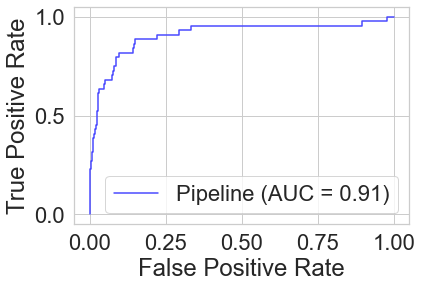

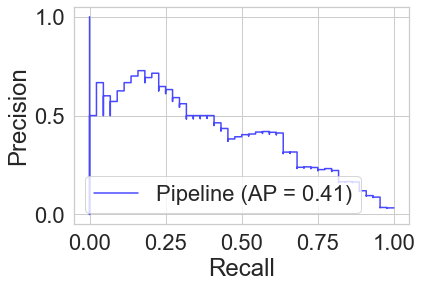

In [102]:
plot_roc_curve(svc, X_test, y_test);
plot_precision_recall_curve(svc, X_test, y_test);

In [74]:
allmodels(svc, 'SVC')

mean f1: 0.0 std: 0.0
[[1320    0]
 [  44    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364

mean f1: 0.8954953866845431 std: 0.002448543315443488
[[1008  312]
 [   5   39]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1320
           1       0.11      0.89      0.20        44

    accuracy                           0.77      1364
   macro avg       0.55      0.82      0.53      1364
weighted avg       0.97      0.77      0.84      1364

mean f1: 0.9165595964771951 std: 0.003058283840608459
[[1093  227]
 [   5   39]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      1320
           1       0.15   

In [75]:
results

,FN,FP,TP,TN,FPR,TPR,ACC,PREC,F1,F1 micro,F1 macro,F1 weighted
LogisticReg,33.00,8.00,11.00,1312.00,0.01,0.25,0.97,0.58,0.35,0.97,0.67,0.96
Tuned LogReg,25.00,28.00,19.00,1292.00,0.02,0.43,0.96,0.40,0.42,0.96,0.70,0.96
Log PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Lograndom over,0.00,610.00,44.00,710.00,0.46,1.00,0.55,0.07,0.13,0.55,0.41,0.68
LogSMOTE,1.00,483.00,43.00,837.00,0.37,0.98,0.65,0.08,0.15,0.65,0.46,0.76
SVC,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Tuned SVC,21.00,34.00,23.00,1286.00,0.03,0.52,0.96,0.40,0.46,0.96,0.72,0.96
SVC PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
SVCrandom over,5.00,312.00,39.00,1008.00,0.24,0.89,0.77,0.11,0.20,0.77,0.53,0.84
SVCSMOTE,5.00,227.00,39.00,1093.00,0.17,0.89,0.83,0.15,0.25,0.83,0.58,0.88


## Naive Bayes - GaussianNB

#### no parameters

In [76]:
nb_pipe = Pipeline([('scale', PowerTransformer()),
                    ('nb', GaussianNB())])

nb_pipe.fit(X_train,y_train)
score(nb_pipe)
output(nb_pipe, 'NB')

Pipeline(steps=[('scale', PowerTransformer()), ('nb', GaussianNB())])

mean f1: 0.33160764938709425 std: 0.04439700124161932
[[1206  114]
 [  12   32]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1320
           1       0.22      0.73      0.34        44

    accuracy                           0.91      1364
   macro avg       0.60      0.82      0.64      1364
weighted avg       0.97      0.91      0.93      1364



#### Tuning

In [81]:
#tuning
nb_pipe = Pipeline([('scale', PowerTransformer()),
                    ('nb', GaussianNB())])

param_grid = {'nb__var_smoothing':np.linspace(0.1, 0.3, num=100)}

grid = GridSearchCV(nb_pipe,
                    param_grid,
                    refit=True,
                    verbose=1, 
                    n_jobs=-1, 
                    cv=kf,
                    scoring='f1')
grid.fit(X_train,y_train)
grid.best_estimator_
grid.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('scale', PowerTransformer()),
                                       ('nb', GaussianNB())]),
             n_jobs=-1,
             param_grid={'nb__var_smoothing': array([0.1       , 0.1020202 , 0.1040404 , 0.10606061, 0.10808081,
       0.11010101, 0.11212121, 0.11414141, 0.11616162, 0.11818182,
       0.12020202, 0.12222222, 0.12424242, 0.12626263, 0.1282...
       0.23131313, 0.23333333, 0.23535354, 0.23737374, 0.23939394,
       0.24141414, 0.24343434, 0.24545455, 0.24747475, 0.24949495,
       0.25151515, 0.25353535, 0.25555556, 0.25757576, 0.25959596,
       0.26161616, 0.26363636, 0.26565657, 0.26767677, 0.26969697,
       0.27171717, 0.27373737, 0.27575758, 0.27777778, 0.27979798,
       0.28181818, 0.28383838, 0.28585859, 0.28787879, 0.28989899,
       0.29191919, 0.29393939, 0.2959596 , 0.2979798 , 0.3       ])},
             scoring='f1', verbose=1)

Pipeline(steps=[('scale', PowerTransformer()),
                ('nb', GaussianNB(var_smoothing=0.22727272727272727))])

{'nb__var_smoothing': 0.22727272727272727}

#### tuned

In [83]:
nb_pipe = Pipeline([('scale', PowerTransformer()),
                    ('nb', GaussianNB(var_smoothing=0.22727272727272727))])

nb_pipe.fit(X_train,y_train)
score(nb_pipe)
output(nb_pipe, 'Tuned NB')

Pipeline(steps=[('scale', PowerTransformer()),
                ('nb', GaussianNB(var_smoothing=0.22727272727272727))])

mean f1: 0.36917504116277744 std: 0.036789772825266284
[[1262   58]
 [  21   23]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1320
           1       0.28      0.52      0.37        44

    accuracy                           0.94      1364
   macro avg       0.63      0.74      0.67      1364
weighted avg       0.96      0.94      0.95      1364



In [85]:
allmodels(nb_pipe, 'NB')

mean f1: 0.0 std: 0.0
[[1320    0]
 [  44    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364

mean f1: 0.8002776008351268 std: 0.004543247415200232
[[1186  134]
 [  10   34]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1320
           1       0.20      0.77      0.32        44

    accuracy                           0.89      1364
   macro avg       0.60      0.84      0.63      1364
weighted avg       0.97      0.89      0.92      1364

mean f1: 0.8826389055596658 std: 0.002181283027982797
[[1123  197]
 [   8   36]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1320
           1       0.15   

In [86]:
results

,FN,FP,TP,TN,FPR,TPR,ACC,PREC,F1,F1 micro,F1 macro,F1 weighted
LogisticReg,33.00,8.00,11.00,1312.00,0.01,0.25,0.97,0.58,0.35,0.97,0.67,0.96
Tuned LogReg,25.00,28.00,19.00,1292.00,0.02,0.43,0.96,0.40,0.42,0.96,0.70,0.96
Log PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Lograndom over,0.00,610.00,44.00,710.00,0.46,1.00,0.55,0.07,0.13,0.55,0.41,0.68
LogSMOTE,1.00,483.00,43.00,837.00,0.37,0.98,0.65,0.08,0.15,0.65,0.46,0.76
SVC,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Tuned SVC,21.00,34.00,23.00,1286.00,0.03,0.52,0.96,0.40,0.46,0.96,0.72,0.96
SVC PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
SVCrandom over,5.00,312.00,39.00,1008.00,0.24,0.89,0.77,0.11,0.20,0.77,0.53,0.84
SVCSMOTE,5.00,227.00,39.00,1093.00,0.17,0.89,0.83,0.15,0.25,0.83,0.58,0.88


## LDA

In [89]:
lda = Pipeline([('scale', PowerTransformer()),
                    ('lda', LinearDiscriminantAnalysis())])

lda.fit(X_train,y_train)
score(lda)
output(lda, 'LDA')

Pipeline(steps=[('scale', PowerTransformer()),
                ('lda', LinearDiscriminantAnalysis())])

mean f1: 0.40158873255560207 std: 0.024797718280696428
[[1303   17]
 [  30   14]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.45      0.32      0.37        44

    accuracy                           0.97      1364
   macro avg       0.71      0.65      0.68      1364
weighted avg       0.96      0.97      0.96      1364



In [91]:
param_grid = {'lda__n_components':[None, 5, 10, 20, 25, 30],
              'lda__solver':['svd', 'lsqr', 'eigen'],
              'lda__shrinkage':['auto', None, 0.25, 0.5, 0.75, 1]}

grid = GridSearchCV(lda,
                    param_grid,
                    refit=True,
                    verbose=1, 
                    n_jobs=-1, 
                    cv=kf,
                    scoring='f1')
grid.fit(X_train,y_train)
grid.best_estimator_
grid.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   18.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('scale', PowerTransformer()),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'lda__n_components': [None, 5, 10, 20, 25, 30],
                         'lda__shrinkage': ['auto', None, 0.25, 0.5, 0.75, 1],
                         'lda__solver': ['svd', 'lsqr', 'eigen']},
             scoring='f1', verbose=1)

Pipeline(steps=[('scale', PowerTransformer()),
                ('lda',
                 LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr'))])

{'lda__n_components': None, 'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}

#### tuned

In [92]:
lda = Pipeline([('scale', PowerTransformer()),
                ('lda', LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr'))])

lda.fit(X_train,y_train)
score(lda)
output(lda, 'Tuned LDA')

Pipeline(steps=[('scale', PowerTransformer()),
                ('lda',
                 LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr'))])

mean f1: 0.42645181173777136 std: 0.052672821996634374
[[1298   22]
 [  28   16]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.42      0.36      0.39        44

    accuracy                           0.96      1364
   macro avg       0.70      0.67      0.69      1364
weighted avg       0.96      0.96      0.96      1364



In [93]:
allmodels(lda, 'LDA')

mean f1: 0.0 std: 0.0
[[1320    0]
 [  44    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364

mean f1: 0.8781955773189001 std: 0.0025990336436888545
[[1118  202]
 [   6   38]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1320
           1       0.16      0.86      0.27        44

    accuracy                           0.85      1364
   macro avg       0.58      0.86      0.59      1364
weighted avg       0.97      0.85      0.89      1364

mean f1: 0.9025119243022727 std: 0.00415283047161576
[[1144  176]
 [   6   38]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1320
           1       0.18   

In [94]:
results

,FN,FP,TP,TN,FPR,TPR,ACC,PREC,F1,F1 micro,F1 macro,F1 weighted
LogisticReg,33.00,8.00,11.00,1312.00,0.01,0.25,0.97,0.58,0.35,0.97,0.67,0.96
Tuned LogReg,25.00,28.00,19.00,1292.00,0.02,0.43,0.96,0.40,0.42,0.96,0.70,0.96
Log PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Lograndom over,0.00,610.00,44.00,710.00,0.46,1.00,0.55,0.07,0.13,0.55,0.41,0.68
LogSMOTE,1.00,483.00,43.00,837.00,0.37,0.98,0.65,0.08,0.15,0.65,0.46,0.76
SVC,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Tuned SVC,21.00,34.00,23.00,1286.00,0.03,0.52,0.96,0.40,0.46,0.96,0.72,0.96
SVC PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
SVCrandom over,5.00,312.00,39.00,1008.00,0.24,0.89,0.77,0.11,0.20,0.77,0.53,0.84
SVCSMOTE,5.00,227.00,39.00,1093.00,0.17,0.89,0.83,0.15,0.25,0.83,0.58,0.88


## QDA

In [95]:
qda = Pipeline([('scale', PowerTransformer()),
                    ('qda', QuadraticDiscriminantAnalysis())])

qda.fit(X_train,y_train)
score(qda)
output(qda, 'QDA')

Pipeline(steps=[('scale', PowerTransformer()),
                ('qda', QuadraticDiscriminantAnalysis())])

mean f1: 0.09925841223987587 std: 0.03663299289785113
[[1244   76]
 [  25   19]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1320
           1       0.20      0.43      0.27        44

    accuracy                           0.93      1364
   macro avg       0.59      0.69      0.62      1364
weighted avg       0.96      0.93      0.94      1364



In [96]:
param_grid = {'qda__reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
              'qda__store_covariance': (True, False)}

grid = GridSearchCV(qda,
                    param_grid,
                    refit=True,
                    verbose=1, 
                    n_jobs=-1, 
                    cv=kf,
                    scoring='f1')
grid.fit(X_train,y_train)
grid.best_estimator_
grid.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=50, shuffle=True),
             estimator=Pipeline(steps=[('scale', PowerTransformer()),
                                       ('qda',
                                        QuadraticDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'qda__reg_param': (1e-05, 0.0001, 0.001, 0.01, 0.1),
                         'qda__store_covariance': (True, False)},
             scoring='f1', verbose=1)

Pipeline(steps=[('scale', PowerTransformer()),
                ('qda',
                 QuadraticDiscriminantAnalysis(reg_param=0.1,
                                               store_covariance=True))])

{'qda__reg_param': 0.1, 'qda__store_covariance': True}

#### Tuned

In [97]:
qda = Pipeline([('scale', PowerTransformer()),
                    ('qda', QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True))])

qda.fit(X_train,y_train)
score(qda)
output(qda, 'Tuned QDA')

Pipeline(steps=[('scale', PowerTransformer()),
                ('qda',
                 QuadraticDiscriminantAnalysis(reg_param=0.1,
                                               store_covariance=True))])

mean f1: 0.3436731500111782 std: 0.05450787159014899
[[1290   30]
 [  30   14]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.32      0.32      0.32        44

    accuracy                           0.96      1364
   macro avg       0.65      0.65      0.65      1364
weighted avg       0.96      0.96      0.96      1364



In [98]:
allmodels(qda, 'QDA')

mean f1: 0.06644042232277526 std: 0.022349850415521736
[[1299   21]
 [  41    3]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1320
           1       0.12      0.07      0.09        44

    accuracy                           0.95      1364
   macro avg       0.55      0.53      0.53      1364
weighted avg       0.94      0.95      0.95      1364

mean f1: 0.8918245148400762 std: 0.005832652532045687
[[1135  185]
 [  11   33]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1320
           1       0.15      0.75      0.25        44

    accuracy                           0.86      1364
   macro avg       0.57      0.80      0.59      1364
weighted avg       0.96      0.86      0.90      1364

mean f1: 0.9127378083362686 std: 0.004087990494982588
[[1106  214]
 [  12   32]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    

In [99]:
results

,FN,FP,TP,TN,FPR,TPR,ACC,PREC,F1,F1 micro,F1 macro,F1 weighted
LogisticReg,33.00,8.00,11.00,1312.00,0.01,0.25,0.97,0.58,0.35,0.97,0.67,0.96
Tuned LogReg,25.00,28.00,19.00,1292.00,0.02,0.43,0.96,0.40,0.42,0.96,0.70,0.96
Log PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Lograndom over,0.00,610.00,44.00,710.00,0.46,1.00,0.55,0.07,0.13,0.55,0.41,0.68
LogSMOTE,1.00,483.00,43.00,837.00,0.37,0.98,0.65,0.08,0.15,0.65,0.46,0.76
SVC,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
Tuned SVC,21.00,34.00,23.00,1286.00,0.03,0.52,0.96,0.40,0.46,0.96,0.72,0.96
SVC PCA,44.00,0.00,0.00,1320.00,1.00,1.00,0.97,0.00,0.00,0.97,0.49,0.95
SVCrandom over,5.00,312.00,39.00,1008.00,0.24,0.89,0.77,0.11,0.20,0.77,0.53,0.84
SVCSMOTE,5.00,227.00,39.00,1093.00,0.17,0.89,0.83,0.15,0.25,0.83,0.58,0.88
